**Importer les bibliothèques**

In [179]:
import logging
logging.getLogger('tensorflow').disabled = True
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # remove WARNING Messages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.maxsize
from google.colab import drive
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers



**initialisation les paramètres**

In [180]:

class fis_parameters():
    def __init__(self, n_input: int = 3, n_memb: int = 3, batch_size: int = 16, n_epochs: int = 25, memb_func: str = 'gaussian', optimizer: str = 'sgd', loss: str = 'mse'):
        self.n_input = n_input
        self.n_memb = n_memb  # no. of fuzzy memberships
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.memb_func = memb_func
        self.optimizer = optimizer
        self.loss = loss

**Main Class ANFIS**

In [181]:
# Main Class ANFIS
class ANFIS:
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func
        input_ = keras.layers.Input(
            shape=(n_input), name='inputLayer', batch_size=self.batch_size)
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(input_)
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        L3 = NormLayer(name='normLayer')(L2)
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')(L3, input_)
        L5 = SummationLayer(name='sumLayer')(L4)
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        if self.memb_func == 'gaussian':
            self.mus, self.sigmas = self.model.get_layer(
                'fuzzyLayer').get_weights()
        elif self.memb_func == 'gbellmf':
            self.a, self.b, self.c = self.model.get_layer(
                'fuzzyLayer').get_weights()
        self.bias, self.weights = self.model.get_layer(
            'defuzzLayer').get_weights()

    def plotmfs(self, show_initial_weights=False):
        n_input = self.n
        n_memb = self.m

        if self.memb_func == 'gaussian':
            mus, sigmas = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            mus, sigmas = mus.reshape(
                (n_memb, n_input, 1)), sigmas.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(mus) - 2 * np.max(abs(sigmas)),
                             np.max(mus) + 2 * np.max(abs(sigmas)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            memb_curves = np.exp(-np.square((xn - mus)) / np.square(sigmas))

            if show_initial_weights:
                mus_init, sigmas_init = np.around(self.init_weights, 2)
                mus_init, sigmas_init = mus_init.reshape(
                    n_memb, n_input, 1), sigmas_init.reshape(n_memb, n_input, 1)
                init_curves = np.exp(-np.square((xn - mus_init)
                                                ) / np.square(sigmas_init))

        elif self.memb_func == 'gbellmf':
            a, b, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            a, b, c = a.reshape((n_memb, n_input, 1)), b.reshape(
                n_memb, n_input, 1), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(a)),
                             np.max(c) + 2 * np.max(abs(a)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            memb_curves = 1 / (1 + np.square((xn - c) / a)**b)

            if show_initial_weights:
                a_init, b_init, c_init = np.around(self.init_weights, 2)
                a_init, b_init, c_init = a_init.reshape((n_memb, n_input, 1)), b_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / \
                    (1 + np.square((xn - c_init) / a_init)**b_init)

        elif self.memb_func == 'sigmoid':
            gammas, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            gammas, c = gammas.reshape(
                (n_memb, n_input, 1)), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(c)), np.max(c) + 2 * np.max(
                abs(c)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            memb_curves = 1 / (1 + np.exp(-gammas * (xn - c)))

            if show_initial_weights:
                gammas_init, c_init = np.around(self.init_weights, 2)
                gammas_init, c_init = gammas_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / (1 + np.exp(-gammas_init * (xn - c_init)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(8, self.n * 2))
        fig.suptitle('Membership functions', size=16)
        for n in range(self.n):
            axs[n].grid(True)
            axs[n].set_title(f'Input {n+1}')
            for m in range(self.m):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :])

        if show_initial_weights:  # plot initial membership curve
            for n in range(self.n):
                axs[n].set_prop_cycle(None)  # reset color cycle
                for m in range(self.m):
                    axs[n].plot(xn[m, n, :], init_curves[m, n, :],
                                '--', alpha=.5)
        plt.show()

    def fit(self, X, y, **kwargs):
        self.init_weights = self.model.get_layer('fuzzyLayer').get_weights()

        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        tf.keras.backend.clear_session()

        return history

    def get_memberships(self, Xs):
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                               outputs=self.model.get_layer('normLayer').output)

        intermediate_L2_output = intermediate_layer_model.predict(Xs)

        return intermediate_L2_output


def equally_spaced_initializer(shape, minval=-1.5, maxval=1.5, dtype=tf.float32):
    """
    Custom weight initializer:
        euqlly spaced weights along an operating range of [minval, maxval].
    """
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]),
                          (-1, 1))
    return tf.Variable(tf.tile(linspace, (1, shape[1])))

**Layer 1 - Fuzzification Layer (Input Layer):**

In [198]:
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]

        if self.memb_func == 'gbellmf':
            self.a = self.add_weight(name='a',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.b = self.add_weight(name='b',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,
                                     #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                     #initializer = 'zeros',
                                     trainable=True)

        elif self.memb_func == 'gaussian':
            self.mu = self.add_weight(name='mu',
                                      shape=(self.m, self.n),
                                      initializer=equally_spaced_initializer,
                                      #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                      #initializer = 'zeros',
                                      trainable=True)
            self.sigma = self.add_weight(name='sigma',
                                         shape=(self.m, self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=.7, maxval=1.3, seed=1),
                                         #initializer = 'ones',
                                         trainable=True)

        elif self.memb_func == 'sigmoid':
            self.gamma = self.add_weight(name='gamma',
                                         shape=(self.m, self.n),
                                         initializer=equally_spaced_initializer,  # 'ones',
                                         trainable=True)

            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,  # 'ones',
                                     trainable=True)

        # Be sure to call this at the end
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        if self.memb_func == 'gbellmf':
            L1_output = 1 / (1 +
                             tf.math.pow(
                                 tf.square(tf.subtract(
                                     tf.reshape(
                                         tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c
                                 ) / self.a), self.b)
                             )
        elif self.memb_func == 'gaussian':
            L1_output = tf.exp(-1 *
                               tf.square(tf.subtract(
                                   tf.reshape(
                                       tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.mu
                               )) / tf.square(self.sigma))

        elif self.memb_func == 'sigmoid':
            L1_output = tf.math.divide(1,
                                       tf.math.exp(-self.gamma *
                                                   tf.subtract(
                                                       tf.reshape(
                                                           tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c)
                                                   )
                                       )
        return L1_output

**Layer 2 - Rule Layer:**

In [197]:
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.batch_size = None

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        # self.batch_size = tf.shape(batch_input_shape)[0]
        # Be sure to call this at the end
        super(RuleLayer, self).build(batch_input_shape)

    def call(self, input_):
        if self.n == 2:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1])
        elif self.n == 3:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1])
        elif self.n == 4:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1])
        elif self.n == 5:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1])
        elif self.n == 6:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 5], [
                           self.batch_size, 1, 1, 1, 1, 1, -1])
        else:
            raise ValueError(
                f'This ANFIS implementation works with 2 to 6 inputs.')

        return tf.reshape(L2_output, [self.batch_size, -1])


 **Layer 3 - Normalization Layer:**

In [184]:
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm

**Layer 4- Defuzzification**

In [185]:
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

        self.CP_bias = self.add_weight(name='Consequence_bias',
                                       shape=(1, self.m ** self.n),
                                       initializer=keras.initializers.RandomUniform(
                                           minval=-2, maxval=2),
                                       trainable=True)
        self.CP_weight = self.add_weight(name='Consequence_weight',
                                         shape=(self.n, self.m ** self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=-2, maxval=2),
                                         trainable=True)

    def call(self, w_norm, input_):

        L4_L2_output = tf.multiply(w_norm,
                                   tf.matmul(input_, self.CP_weight) + self.CP_bias)
        return L4_L2_output



**Layer 5- Summation**

In [199]:
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]

        super(SummationLayer, self).build(batch_input_shape)

    def call(self, input_):
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output


**Importation data**

In [187]:
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [188]:

chemin_fichier_csv = '/content/mydrive/MyDrive/traffic.csv'
df = pd.read_csv(chemin_fichier_csv)
print(df.head())

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [189]:
df.to_numpy()

array([['2015-11-01 00:00:00', 1, 15, 20151101001],
       ['2015-11-01 01:00:00', 1, 13, 20151101011],
       ['2015-11-01 02:00:00', 1, 10, 20151101021],
       ...,
       ['2017-06-30 21:00:00', 4, 16, 20170630214],
       ['2017-06-30 22:00:00', 4, 22, 20170630224],
       ['2017-06-30 23:00:00', 4, 12, 20170630234]], dtype=object)

In [190]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


**Apliquer la normalisation Min-Max**


In [191]:
colonnes_numeriques = df.select_dtypes(include=['number']).columns
df_numerique = df[colonnes_numeriques]
# Appliquer la normalisation Min-Max
scaler = MinMaxScaler()
df2 = pd.DataFrame(scaler.fit_transform(df_numerique), columns=colonnes_numeriques)
print(df2.head())

   Junction  Vehicles            ID
0       0.0  0.078212  0.000000e+00
1       0.0  0.067039  5.120530e-07
2       0.0  0.050279  1.024106e-06
3       0.0  0.033520  1.536159e-06
4       0.0  0.044693  2.048212e-06


In [192]:
X = df2.iloc[:, 0:3]
Y = df2.iloc[:, -1]

display(X)
display(Y)


,Junction,Vehicles,ID
0,0.0,0.078212,0.000000e+00
1,0.0,0.067039,5.120530e-07
2,0.0,0.050279,1.024106e-06
3,0.0,0.033520,1.536159e-06
4,0.0,0.044693,2.048212e-06
...,...,...,...
48115,1.0,0.055866,9.999980e-01
48116,1.0,0.162011,9.999985e-01
48117,1.0,0.083799,9.999990e-01
48118,1.0,0.117318,9.999995e-01


0        0.000000e+00
1        5.120530e-07
2        1.024106e-06
3        1.536159e-06
4        2.048212e-06
             ...     
48115    9.999980e-01
48116    9.999985e-01
48117    9.999990e-01
48118    9.999995e-01
48119    1.000000e+00
Name: ID, Length: 48120, dtype: float64

In [193]:
param = fis_parameters(
            n_input = 3,
            n_memb = 3,
            batch_size =1,
            memb_func = 'gaussian',
            optimizer = 'adam',
            #loss = tf.keras.losses.MeanAbsolutePercentageError(),
            loss = 'mean_absolute_percentage_error',               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
            n_epochs = 20
            )

In [194]:
histories=[]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [195]:
fis = ANFIS(n_input = param.n_input,
                        n_memb = param.n_memb,
                        batch_size = param.batch_size,
                        memb_func = param.memb_func,
                        name = 'myanfis'
                        )

In [200]:
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
                  metrics=['mae', 'mse']
                  )

In [201]:
history = fis.fit(X_train, y_train,
                      epochs=param.n_epochs,
                      batch_size=param.batch_size,
                      validation_data = (X_test, y_test),
                      )
histories.append(history)

Epoch 1/20
33684/33684 [==============================] - 83s 2ms/step - loss: 9432.7197 - mae: 0.0537 - mse: 0.0124 - val_loss: 5345.2524 - val_mae: 0.0237 - val_mse: 0.0011
Epoch 2/20
33684/33684 [==============================] - 85s 3ms/step - loss: 4698.6812 - mae: 0.0246 - mse: 0.0013 - val_loss: 7551.7593 - val_mae: 0.0203 - val_mse: 9.5565e-04
Epoch 3/20
33684/33684 [==============================] - 83s 2ms/step - loss: 4747.4277 - mae: 0.0193 - mse: 8.1570e-04 - val_loss: 896.9547 - val_mae: 0.0339 - val_mse: 0.0019
Epoch 4/20
33684/33684 [==============================] - 85s 3ms/step - loss: 4379.3018 - mae: 0.0175 - mse: 6.5017e-04 - val_loss: 504.8167 - val_mae: 0.0118 - val_mse: 2.2637e-04
Epoch 5/20
33684/33684 [==============================] - 88s 3ms/step - loss: 1408.7711 - mae: 0.0171 - mse: 6.3750e-04 - val_loss: 3141.3640 - val_mae: 0.0619 - val_mse: 0.0043
Epoch 6/20
33684/33684 [==============================] - 86s 3ms/step - loss: 2324.6924 - mae: 0.0158 - ms

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


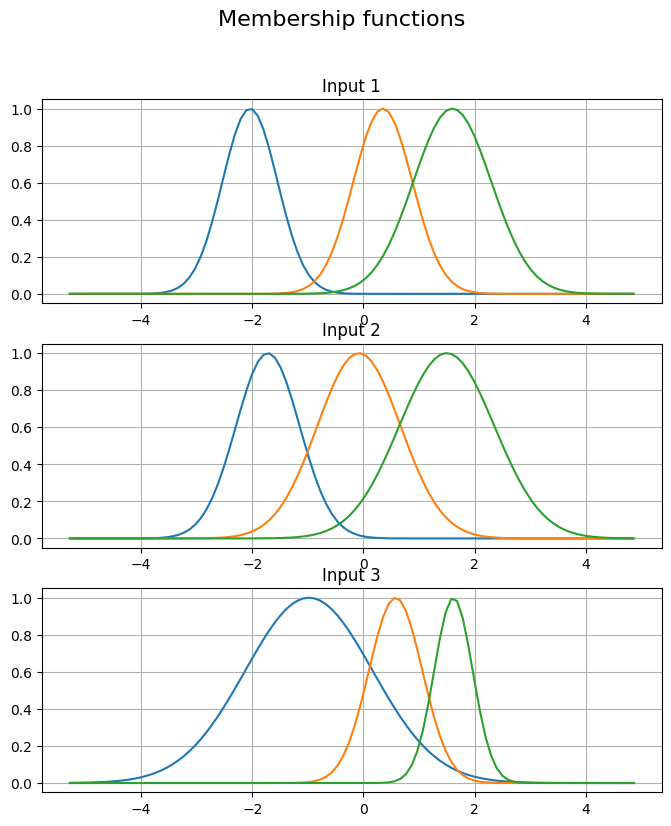

In [116]:
fis.plotmfs()


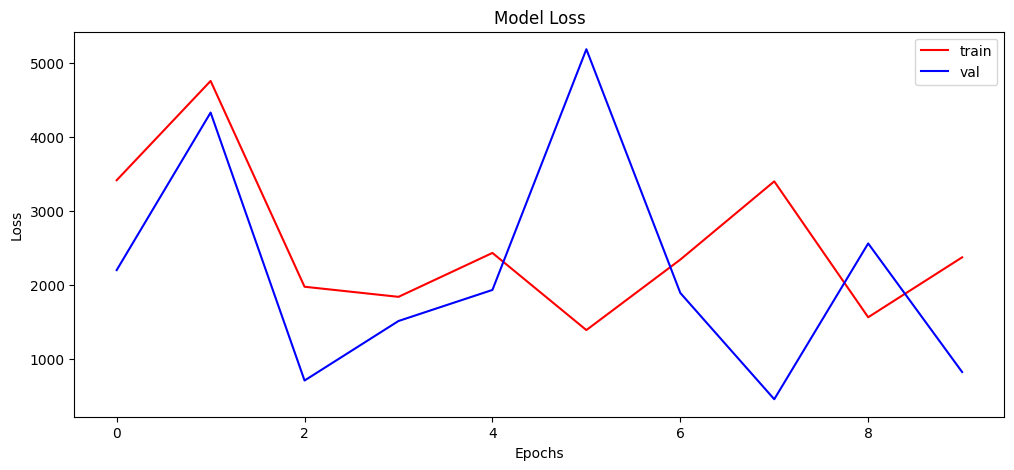

In [117]:

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

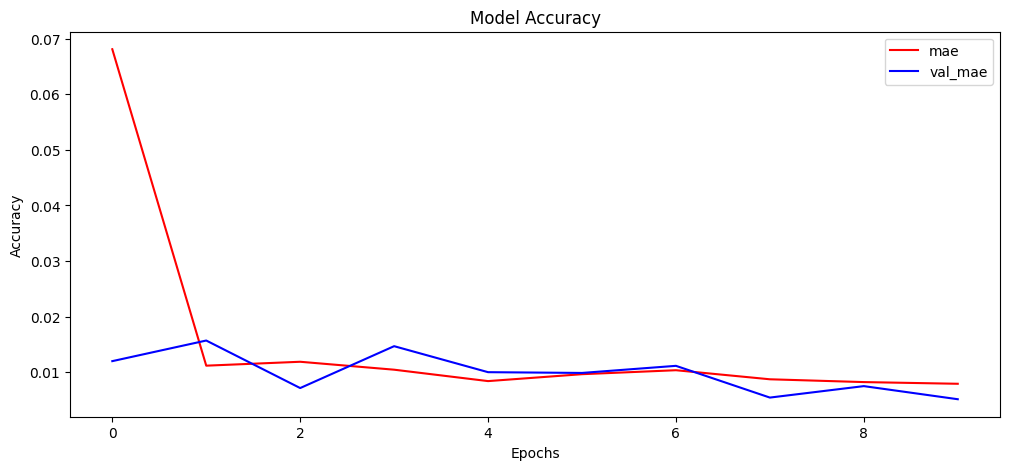

In [118]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], color='r')
plt.plot(history.history['val_mae'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mae', 'val_mae'])
plt.show()


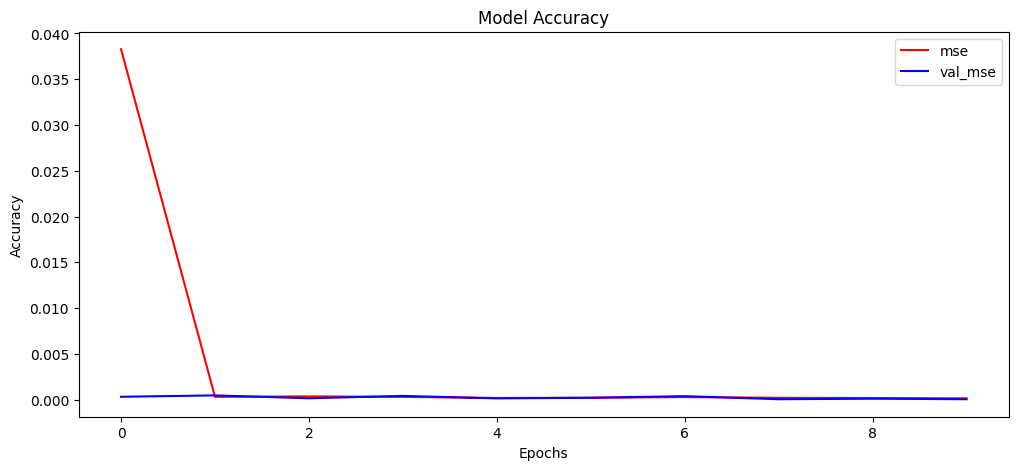

In [119]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['mse'], color='r')
plt.plot(history.history['val_mse'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mse', 'val_mse'])
plt.show()

In [ ]:
a=fis.model.summary()


Model: "myanfis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(1, 3)]                     0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (1, 3, 3)                    18        ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (1, 27)                      0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (1, 27)                      0         ['ruleLayer[0][0]']           
                                                                                            

In [ ]:
print(X_test.shape)

y_test.shape

#pred= fis.model.predict(X_test)


(14436, 3)


(14436,)

In [ ]:
y_pred = fis(X_test)

14436/14436 [==============================] - 24s 2ms/step


14436/14436 [==============================] - 29s 2ms/step


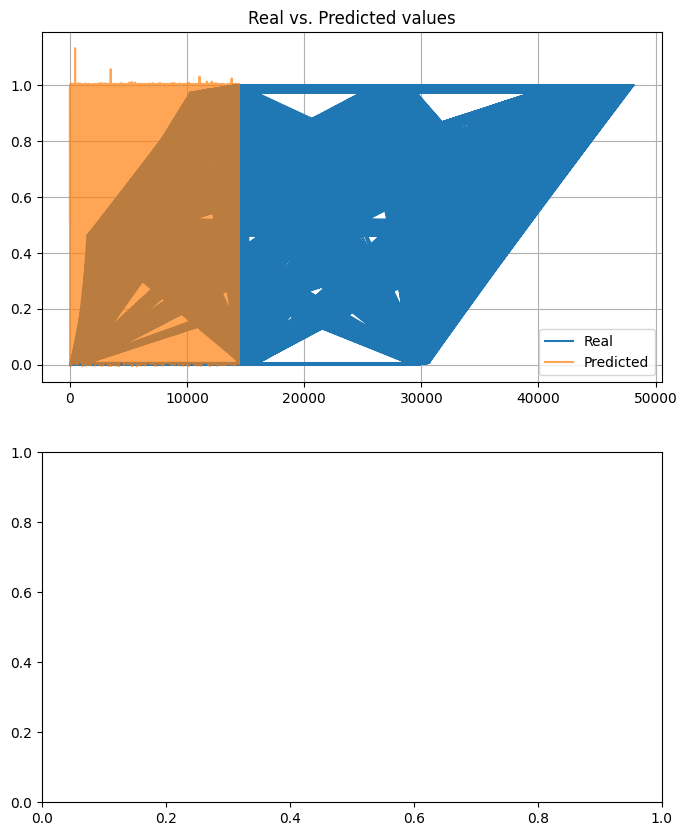

In [120]:
plot_prediction=True
if plot_prediction:
    y_pred = fis(X_test)
    f, axs = plt.subplots(2, 1, figsize=(8, 10))
    # f.suptitle(f'{gen.get_data_name(data_id)} time series', size=16)
    axs[0].plot(y_test)
    axs[0].plot(y_pred, alpha=.7)
    axs[0].legend(['Real', 'Predicted'])
    axs[0].grid(True)
    axs[0].set_title('Real vs. Predicted values')

    plt.show()